In [1]:
from util.log import plot_ts_result
from util.process import MyDataset, Modeling
from util.model import TransformerModel, LSTM

import numpy as np
import pandas as pd

df = pd.read_csv("data/merged_fill.csv") 
df["INNER_HMDT"] = (df["INNER_HMDT_1"] + df["INNER_HMDT_2"]) / 2
df["INNER_TPRT"] = (df["INNER_TPRT_1"] + df["INNER_TPRT_2"]) / 2


In [2]:
x_cols = ["EXTN_TPRT", "INNER_HMDT"] #"DWP_TPRT"를 넣으면 Transformer에서 거의 100점짜리 답안이 나옴
y_cols = ["INNER_TPRT"]
data = MyDataset(df, x_cols, y_cols)
train_loader, test_loader = data.preprocessing(train_ratio=0.8)

Transformer

Using device: cuda


In [5]:
modeling = Modeling(model=TransformerModel, 
                    data=data, lr=0.001)
modeling.train(
    epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
)

Epoch 10/100, Training Loss: 3.7005083560943604, Validation Loss: 5.84064911
Epoch 20/100, Training Loss: 3.8310387134552, Validation Loss: 6.54949167
Epoch 30/100, Training Loss: 9.482227325439453, Validation Loss: 6.18179703
Epoch 40/100, Training Loss: 6.875877380371094, Validation Loss: 6.61337383
Epoch 50/100, Training Loss: 3.979473114013672, Validation Loss: 6.35833449
Epoch 60/100, Training Loss: 7.1601152420043945, Validation Loss: 6.20999549
Epoch 70/100, Training Loss: 4.771245956420898, Validation Loss: 6.13124279
Epoch 80/100, Training Loss: 3.493208646774292, Validation Loss: 6.73790153
Epoch 90/100, Training Loss: 4.557068824768066, Validation Loss: 6.69910675
Epoch 100/100, Training Loss: 7.757843971252441, Validation Loss: 6.99558311


explained_variance:  0.7315
r2:  0.7306
MAE:  2.1633
MSE:  6.7282
RMSE:  2.5939


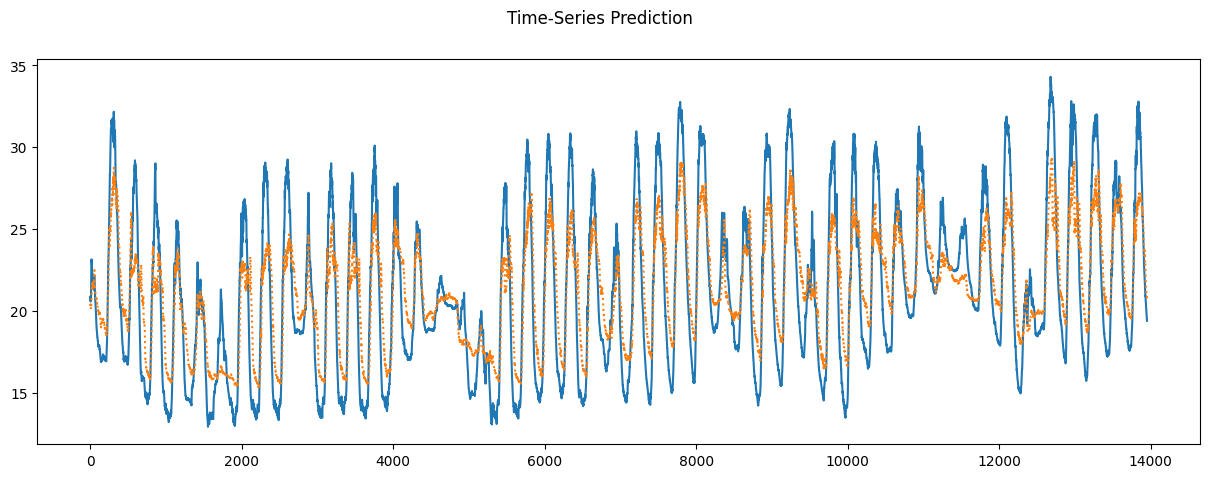

In [6]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
plot_ts_result(true_val, pred_val)

In [4]:
del modeling

LSTM

In [4]:
modeling = Modeling(model=LSTM, 
                    data=data, lr=0.001)
modeling.train(
    epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
)

Epoch 10/100, Training Loss: 7.321533203125, Validation Loss: 11.59902436
Epoch 20/100, Training Loss: 7.588305950164795, Validation Loss: 8.87514428
Epoch 30/100, Training Loss: 6.805191516876221, Validation Loss: 6.99730782
Epoch 40/100, Training Loss: 5.152763366699219, Validation Loss: 6.91859581
Epoch 50/100, Training Loss: 4.477734565734863, Validation Loss: 5.91767264
Epoch 60/100, Training Loss: 6.759608745574951, Validation Loss: 6.17497177
Epoch 70/100, Training Loss: 5.047105312347412, Validation Loss: 6.17027539
Epoch 80/100, Training Loss: 3.574458599090576, Validation Loss: 6.10964896
Epoch 90/100, Training Loss: 4.538712501525879, Validation Loss: 6.45680823
Epoch 100/100, Training Loss: 5.787598609924316, Validation Loss: 6.58870383


explained_variance:  0.7921
r2:  0.7882
MAE:  1.8899
MSE:  5.2887
RMSE:  2.2997


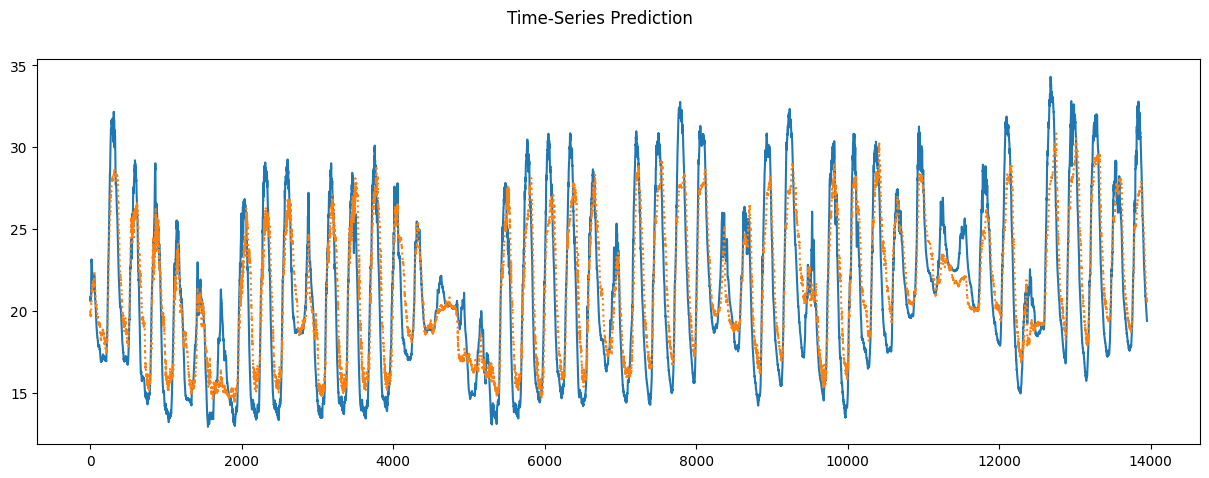

In [5]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
plot_ts_result(true_val, pred_val)

분류부터 딥러닝으로 설계하는 연습을 해보자


reinforcement learning

In [5]:
true_val, pred_val = modeling.eval(train_loader, data.y_train)
batch_size = 32
X = df[x_cols][:len(train_loader)*batch_size]
y = df[y_cols][:len(train_loader)*batch_size]
X["pred"] = pred_val

explained_variance:  -0.6816
r2:  -0.6848
MAE:  3.8395
MSE:  24.4109
RMSE:  4.9407


In [9]:
# absv = np.abs(true_val-pred_val)
# unique, counts = np.unique(np.ceil(absv), return_counts=True)
# dd = dict(zip(unique, counts))
# dd

{0.0: 218,
 1.0: 662914255,
 2.0: 514112358,
 3.0: 377971054,
 4.0: 289503435,
 5.0: 228529087,
 6.0: 196123214,
 7.0: 186968445,
 8.0: 159277453,
 9.0: 124032264,
 10.0: 107664640,
 11.0: 93426924,
 12.0: 70148502,
 13.0: 55257376,
 14.0: 33915392,
 15.0: 15933559,
 16.0: 5063155,
 17.0: 784226,
 18.0: 54688,
 19.0: 139}

In [46]:
# FIXED TICK SIZE

import torch
import gym
from gym import spaces
import numpy as np

class GreenhouseTSEnv(gym.Env):
    def __init__(self, data, tick=4): # data is a batch
        super(GreenhouseTSEnv, self).__init__()

        self.tick = tick
        self.history = data
        self.current_step = -1
        batch_size, input_size = data[0].shape
        self.max_steps = batch_size

        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(input_size,))
        # Action space: Up, Hold, Down
        self.action_space = spaces.Discrete(3)
        self.actions = {0: self.tick, 1: 0, 2: -self.tick}

    def reset(self):
        self.current_step = -1
        return self.history[0][self.current_step]

    def step(self, action):
        self.current_step += 1
        pred = self.history[0][self.current_step][-1]
        answer = self.history[1][self.current_step][-1]
        before_diff = abs(torch.tensor(pred) - answer)

        
        # if abs(pred-answer) <= self.tick:
        #     action = 1
        pred += self.actions[action]
        # pred += self.actions[action] \
        #     if abs(pred-answer) >= self.tick else \
        #     self.actions[action]/2
        
        after_diff = abs(torch.tensor(pred) - answer)
        if before_diff < after_diff:
            after_diff *= 100
        reward = - after_diff
        observation = self.history[0][self.current_step]
        done = self.current_step > self.max_steps 

        return observation, reward, done, {"new_pred": pred}

In [23]:
# Env가 잘 만들어졌는데 실행시키는 코드
batch_size = 4

for z in range(0, len(df), batch_size):
    env = GreenhouseTSEnv([
        df[x_cols].iloc[z:z+batch_size].to_numpy(),
        df[y_cols].iloc[z:z+batch_size].to_numpy()
    ])

    observation = env.reset()
    for i in range(env.max_steps):
        pred = pred_val[0:32][i]
        action = env.action_space.sample()  # Random action for now
        observation, reward, done, _ = env.step(action)
        print(action, observation, reward, done)
        if done:
            print("done")
            break
    break

2 [19.4   62.525] tensor(-34.6500, dtype=torch.float64) False
2 [19.55  64.225] tensor(-36.4500, dtype=torch.float64) False
2 [19.3  64.45] tensor(-36.8250, dtype=torch.float64) False
0 [19.7   65.675] tensor(-46.4750, dtype=torch.float64) False


In [24]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network for Q-function approximation
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple(
            "Experience", field_names=["state", "action", "reward", "next_state", "done"]
        )

    def append(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(DEVICE)  # GPU로 이동
        actions = torch.LongTensor(np.array([e.action for e in batch])).to(DEVICE)  # GPU로 이동
        rewards = torch.FloatTensor(np.array([e.reward for e in batch])).to(DEVICE)  # GPU로 이동
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(DEVICE)  # GPU로 이동
        dones = torch.BoolTensor(np.array([e.done for e in batch])).to(DEVICE)  # GPU로 이동
        return states, actions, rewards, next_states, dones

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=32, gamma=0.99, lr=1e-3, update_freq=4, target_update_freq=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_freq = update_freq
        self.target_update_freq = target_update_freq
        self.q_network = DQN(state_size, action_size).to(DEVICE)  # GPU로 이동
        self.target_network = DQN(state_size, action_size).to(DEVICE)  # GPU로 이동
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.steps = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)  # GPU로 이동
            q_values = self.q_network(state)
            return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

Episode: 50, Reward: -4.604956865310673, Epsilon: 0.778312557068642
Episode: 100, Reward: -4.330836753273013, Epsilon: 0.6057704364907278
Episode: 150, Reward: -4.060473118019106, Epsilon: 0.47147873742168567
Episode: 200, Reward: -4.020169633865363, Epsilon: 0.3669578217261671
Episode: 250, Reward: -3.8110617031097385, Epsilon: 0.285607880564032
Episode: 300, Reward: -3.893550063323974, Epsilon: 0.22229219984074702
Episode: 350, Reward: -3.8275475303649884, Epsilon: 0.1730128104744653
Episode: 400, Reward: -3.810284681701662, Epsilon: 0.1346580429260134
Episode: 450, Reward: -3.7580537054061933, Epsilon: 0.10480604571960442
Episode: 500, Reward: -3.9568998624801637, Epsilon: 0.08157186144027828
Episode: 550, Reward: -3.8358712417602616, Epsilon: 0.06348840406243188
Episode: 600, Reward: -3.670519623756408, Epsilon: 0.0494138221100385
Episode: 650, Reward: -3.4545932018280037, Epsilon: 0.03845939824099909
Episode: 700, Reward: -3.5336816547393832, Epsilon: 0.029933432588273214
Episode:

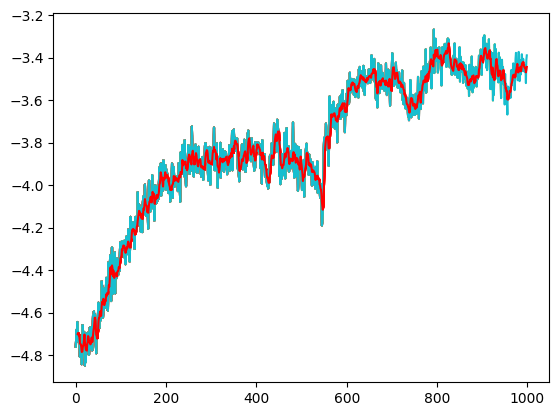

In [25]:
# with GPU: 22 min
window_size = 2000
for z in range(0, len(df), window_size):
    temp = X.iloc[z:z+window_size]
    env = GreenhouseTSEnv([
        temp.to_numpy(),
        y.iloc[z:z+window_size].to_numpy(),
    ])
    break

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
max_episodes = 1000
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha.png")


Episode: 50, Reward: -3.474605303192141, Epsilon: 0.01
Episode: 100, Reward: -3.4311743574142466, Epsilon: 0.01
Episode: 150, Reward: -3.442358953666688, Epsilon: 0.01
Episode: 200, Reward: -3.525695698738097, Epsilon: 0.01
Episode: 250, Reward: -3.3701098098754914, Epsilon: 0.01
Episode: 300, Reward: -3.4639978311538746, Epsilon: 0.01
Episode: 350, Reward: -3.5227713813781802, Epsilon: 0.01
Episode: 400, Reward: -3.3629353210449264, Epsilon: 0.01
Episode: 450, Reward: -3.437051175308233, Epsilon: 0.01
Episode: 500, Reward: -3.369308002281196, Epsilon: 0.01
Episode: 550, Reward: -3.603645804595949, Epsilon: 0.01
Episode: 600, Reward: -3.498074572181703, Epsilon: 0.01
Episode: 650, Reward: -3.4599453117370604, Epsilon: 0.01
Episode: 700, Reward: -3.4334863084793117, Epsilon: 0.01


KeyboardInterrupt: 

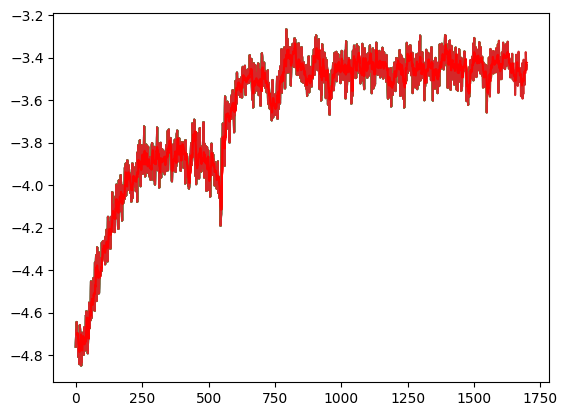

In [26]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha.png")


In [27]:
torch.save(agent.q_network, 'q_model.pth')
torch.save(agent.target_network, 'target_model.pth')


In [ ]:
new_agent = torch.load('model.pth')


In [106]:
# # without GPU: 35min
# window_size = 2000
# for z in range(0, len(df), window_size):
#     temp = X.iloc[z:z+window_size]
#     env = GreenhouseTSEnv([
#         temp.to_numpy(),
#         y.iloc[z:z+window_size].to_numpy(),
#     ])
#     break

# state_size = env.observation_space.shape[-1]
# action_size = env.action_space.n
# agent = DQNAgent(state_size, action_size)

# # Define training parameters
# epsilon_start = 1.0
# epsilon_final = 0.01
# epsilon_decay = 0.995
# max_episodes = 1000
# max_steps_per_episode = env.max_steps

# epsilon = epsilon_start
# for episode in range(1, max_episodes + 1):
#     state = env.reset()
#     episode_reward = 0
#     for step in range(max_steps_per_episode):
#         action = agent.select_action(state, epsilon)
#         next_state, reward, done, _ = env.step(action)
#         agent.store_experience(state, action, reward, next_state, done)
#         agent.train()
#         state = next_state
#         episode_reward += reward
#         if done:
#             break
#     epsilon = max(epsilon_final, epsilon * epsilon_decay)
#     if episode % 50 == 0:
#       print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")


Episode: 50, Reward: -6421.471255760197, Epsilon: 0.778312557068642
Episode: 100, Reward: -5828.58035274504, Epsilon: 0.6057704364907278
Episode: 150, Reward: -5307.986552009577, Epsilon: 0.47147873742168567
Episode: 200, Reward: -4929.675437736502, Epsilon: 0.3669578217261671
Episode: 250, Reward: -4741.240033226007, Epsilon: 0.285607880564032
Episode: 300, Reward: -4436.713782844539, Epsilon: 0.22229219984074702
Episode: 350, Reward: -4172.421763496396, Epsilon: 0.1730128104744653
Episode: 400, Reward: -4331.708217964168, Epsilon: 0.1346580429260134
Episode: 450, Reward: -3968.0347045516946, Epsilon: 0.10480604571960442
Episode: 500, Reward: -3945.682332649232, Epsilon: 0.08157186144027828
Episode: 550, Reward: -3884.6431869888283, Epsilon: 0.06348840406243188
Episode: 600, Reward: -3929.8475391769407, Epsilon: 0.0494138221100385
Episode: 650, Reward: -3885.509921073907, Epsilon: 0.03845939824099909
Episode: 700, Reward: -3864.45169445038, Epsilon: 0.029933432588273214
Episode: 750, 

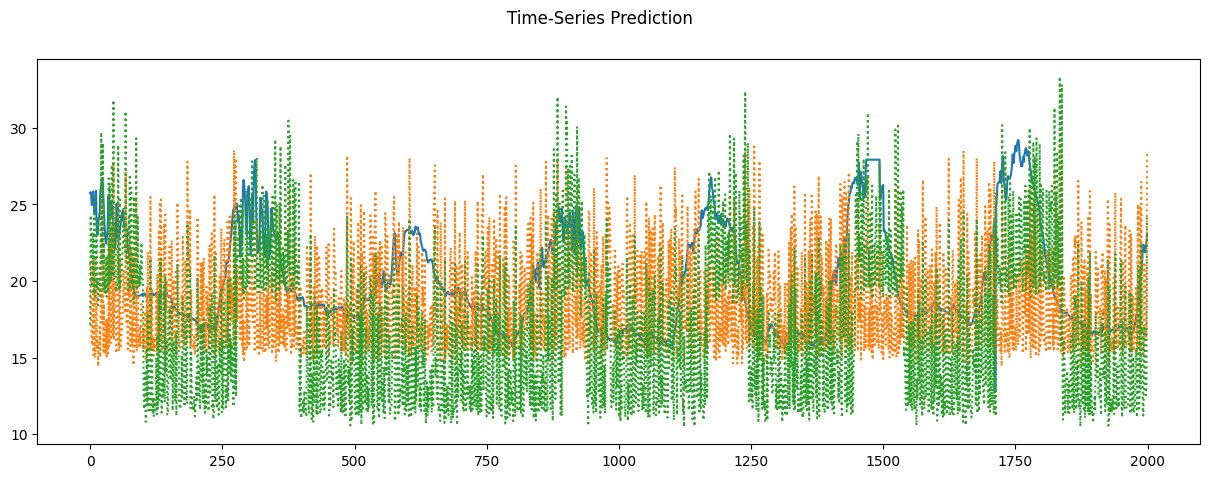

explained_variance:  -0.9378
r2:  -1.1339
MAE:  3.8715
MSE:  23.5485
RMSE:  4.8527
explained_variance:  -0.5835
r2:  -1.5085
MAE:  4.3881
MSE:  27.6825
RMSE:  5.2614


In [28]:
from util.log import regression_results

new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    pred = pred_val[step]
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break

plot_ts_result(true_val[:window_size], pred_val[:window_size], new_pred_val)

# 개선 전
regression_results(true_val[:window_size], pred_val[:window_size])
# 개선 후
regression_results(true_val[:window_size], new_pred_val)

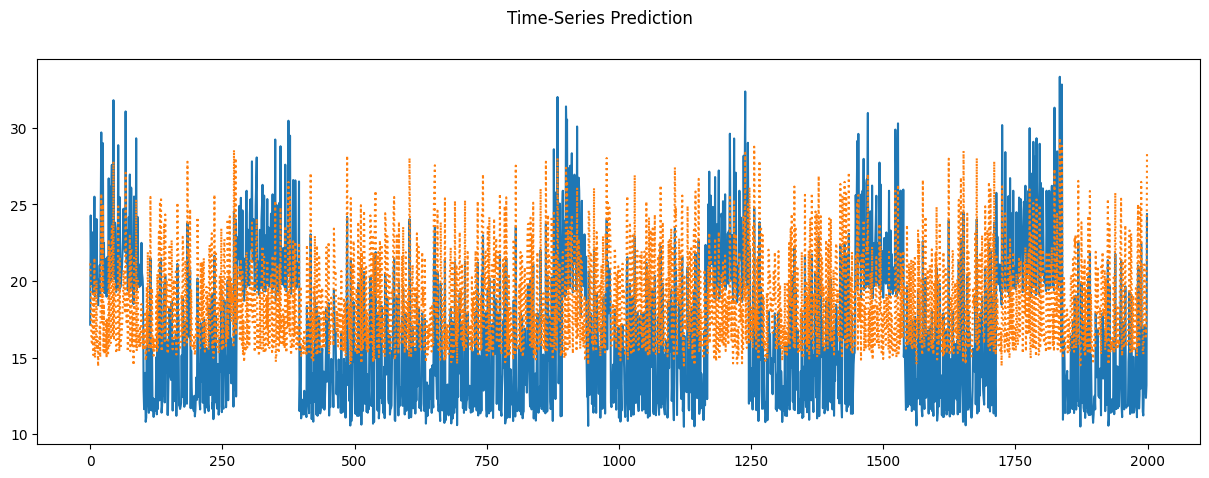

In [29]:
plot_ts_result(new_pred_val, pred_val[:window_size])

explained_variance:  0.745
r2:  0.7361
MAE:  2.0735
MSE:  6.5887
RMSE:  2.5668


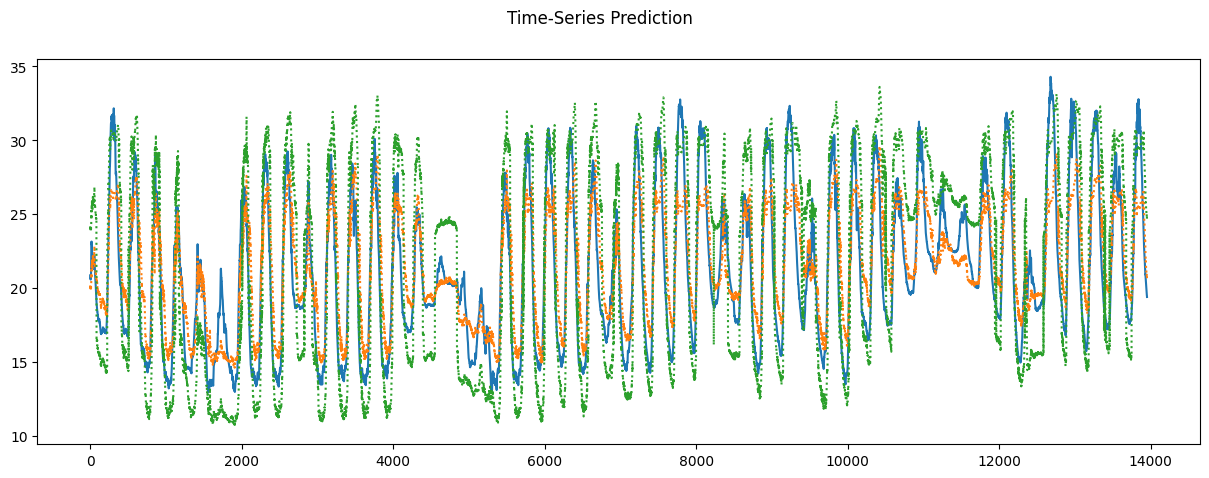

explained_variance:  0.745
r2:  0.7361
MAE:  2.0735
MSE:  6.5887
RMSE:  2.5668
explained_variance:  0.3964
r2:  0.3709
MAE:  3.3433
MSE:  15.7079
RMSE:  3.9633


In [30]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
plot_ts_result(true_val[:new_batch], pred_val[:new_batch],new_pred_val)

# 개선 전
regression_results(true_val[:new_batch], pred_val[:new_batch])
# 개선 후
regression_results(true_val[:new_batch], new_pred_val)

Episode: 50, Reward: -248.3108439784049, Epsilon: 0.9512056281970315
Episode: 100, Reward: -230.02802852315907, Epsilon: 0.9047921471137096
Episode: 150, Reward: -222.66170951013555, Epsilon: 0.8606433826830369
Episode: 200, Reward: -213.24463635768902, Epsilon: 0.818648829478636
Episode: 250, Reward: -196.15011966419198, Epsilon: 0.7787033741169904
Episode: 300, Reward: -195.0820155509949, Epsilon: 0.7407070321560997
Episode: 350, Reward: -176.7588825073241, Epsilon: 0.704564697832001
Episode: 400, Reward: -160.02389142303468, Epsilon: 0.6701859060067403
Episode: 450, Reward: -144.1980123898505, Epsilon: 0.6374846057319378
Episode: 500, Reward: -156.0718756016729, Epsilon: 0.6063789448611848
Episode: 550, Reward: -142.16869624938943, Epsilon: 0.5767910651721362
Episode: 600, Reward: -133.98096340570453, Epsilon: 0.5486469074854965
Episode: 650, Reward: -123.87612494964591, Epsilon: 0.5218760262931003
Episode: 700, Reward: -139.43272307415, Epsilon: 0.4964114134310989
Episode: 750, Rew

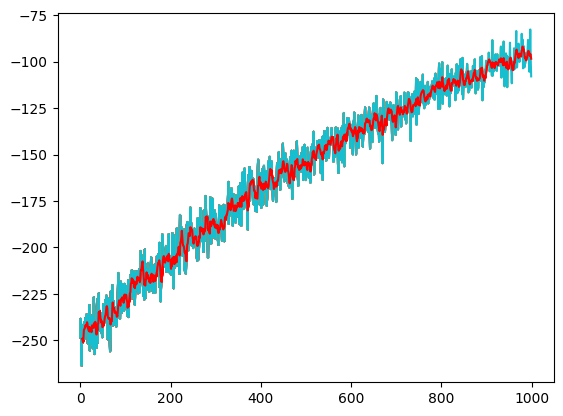

In [48]:
# with GPU: 22 min
window_size = 2000

temp = X.iloc[:window_size]
env = GreenhouseTSEnv([
    temp.to_numpy(),
    y.iloc[:window_size].to_numpy(),
],
tick=3
)

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.999
max_episodes = 1000
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha_explore_new_reward.png")


explained_variance:  0.745
r2:  0.7361
MAE:  2.0735
MSE:  6.5887
RMSE:  2.5668
explained_variance:  0.8008
r2:  0.6868
MAE:  2.2696
MSE:  7.8212
RMSE:  2.7966


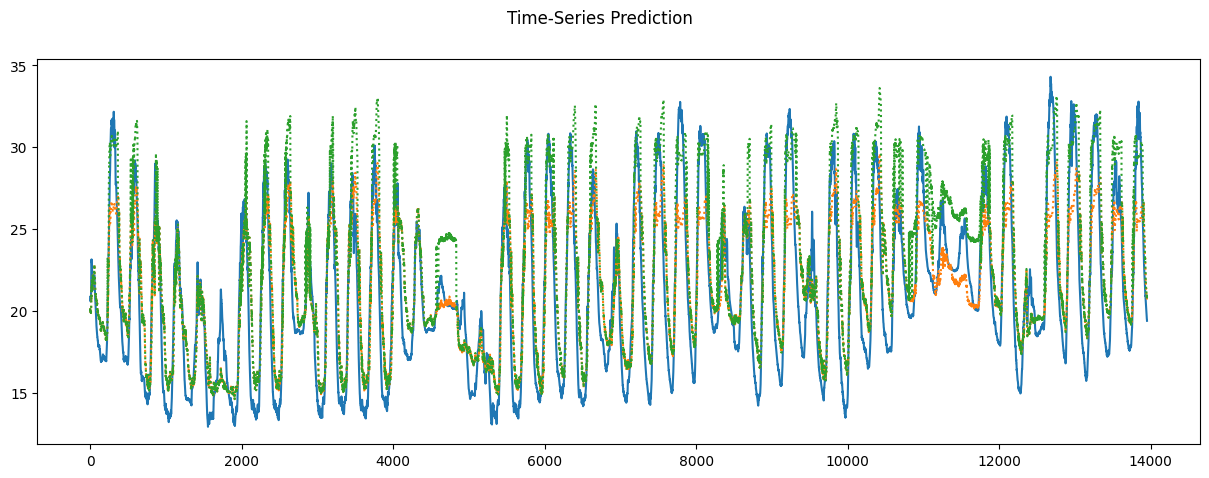

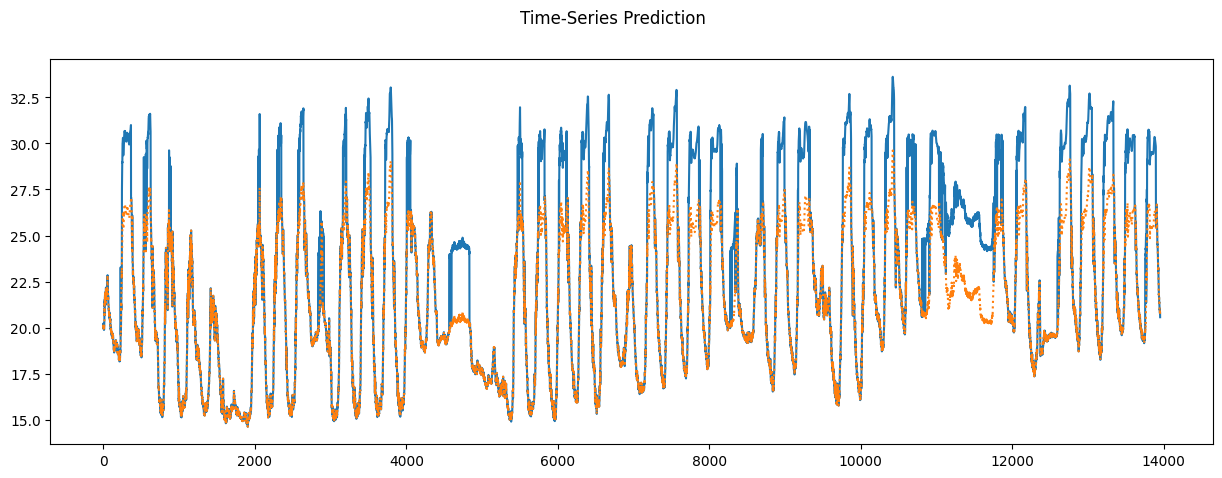

In [49]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val,new_pred_val)
plot_ts_result(new_pred_val, pred_val)

Episode: 50, Reward: -35.02680447830207, Epsilon: 0.01
Episode: 100, Reward: -38.679609385700445, Epsilon: 0.01
Episode: 150, Reward: -35.170526000385465, Epsilon: 0.01


KeyboardInterrupt: 

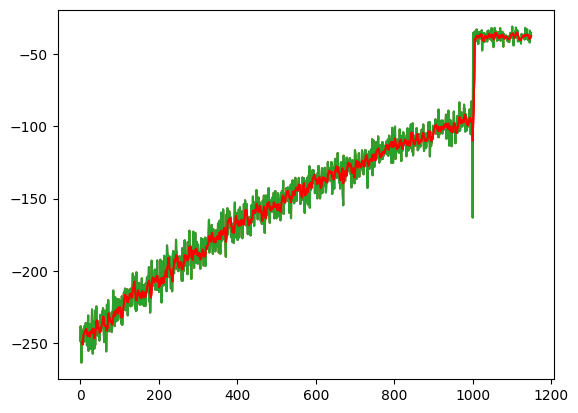

In [50]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha_explore_new_reward.png")

In [53]:
torch.save(agent.q_network, 'q_model.pth')
torch.save(agent.target_network, 'target_model.pth')


In [47]:
# for episode in range(1, max_episodes + 1):
#     state = env.reset()
#     episode_reward = 0
#     for step in range(max_steps_per_episode):
#         action = agent.select_action(state, epsilon)
#         next_state, reward, done, _ = env.step(action)
#         reward = reward/window_size
#         agent.store_experience(state, action, reward, next_state, done)
#         agent.train()
#         state = next_state
#         episode_reward += reward
#         if done:
#             break
#     epsilon = max(epsilon_final, epsilon * epsilon_decay)
#     episode_rewards.append(episode_reward)
#     if episode % 50 == 0:
#       print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
#       plt.plot(episode_rewards)
#       moving_average = np.convolve(
#           episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
#       plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
#                moving_average, label=f'{moving_average_window}-Times Moving Average', 
#                color='red')
#       plt.savefig("rewards_ha_explore_new_reward.png")


KeyboardInterrupt: 

explained_variance:  0.745
r2:  0.7361
MAE:  2.0735
MSE:  6.5887
RMSE:  2.5668
explained_variance:  0.8076
r2:  0.8003
MAE:  1.8402
MSE:  4.9873
RMSE:  2.2332


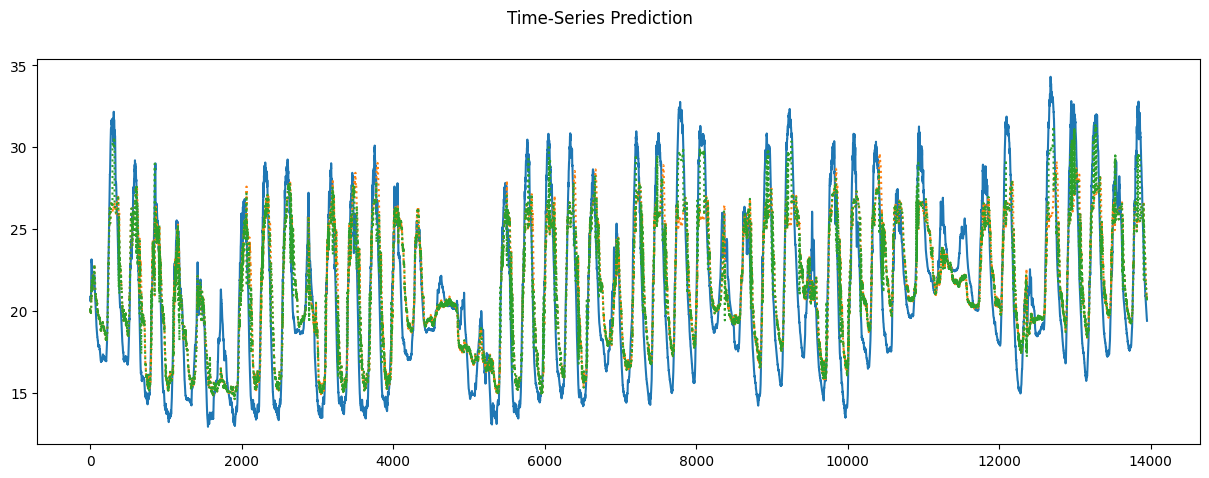

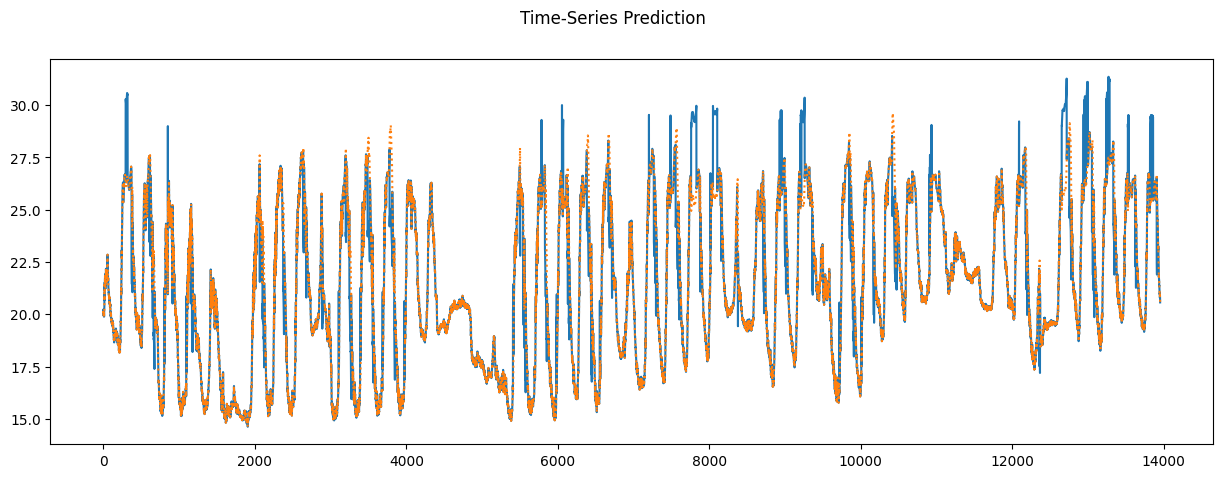

In [51]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val[:new_batch], new_pred_val)

plot_ts_result(true_val[:new_batch], pred_val[:new_batch],new_pred_val)
plot_ts_result(new_pred_val, pred_val)

explained_variance:  -0.6745
r2:  -0.6777
MAE:  3.8316
MSE:  24.3085
RMSE:  4.9304
explained_variance:  -0.6935
r2:  -0.6971
MAE:  3.874
MSE:  24.5893
RMSE:  4.9588


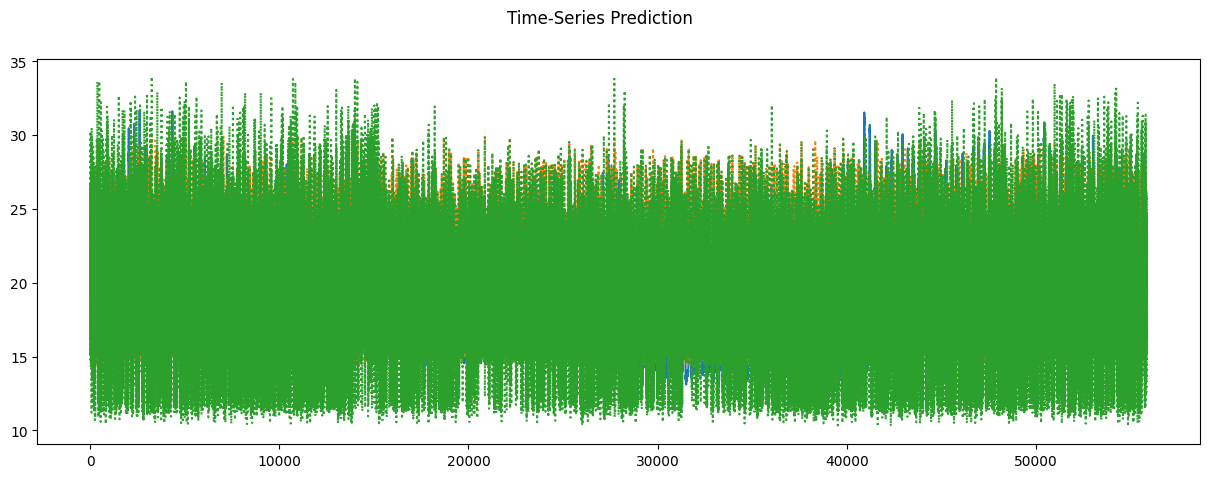

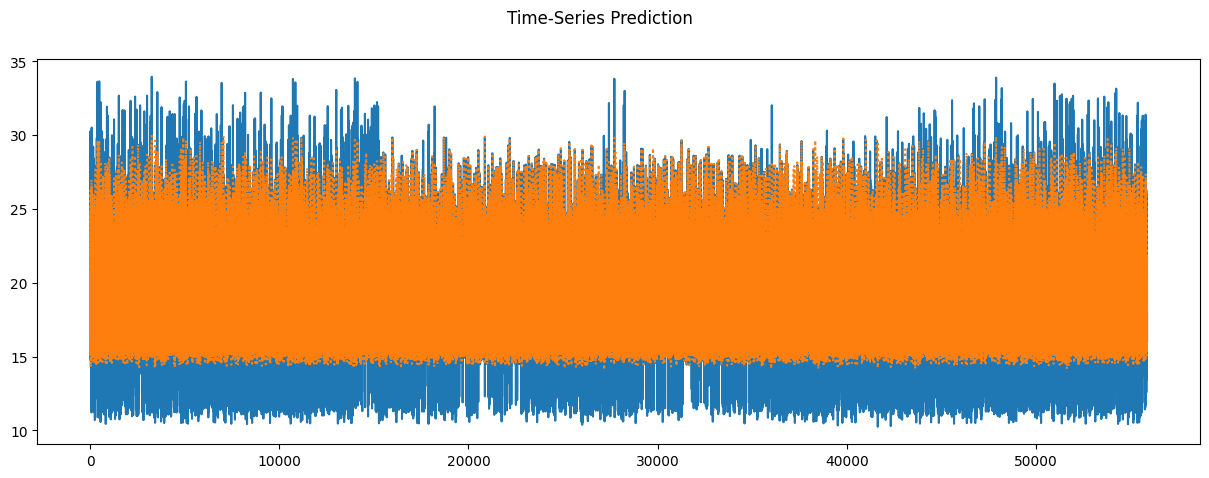

In [52]:
true_val, pred_val = modeling.eval(train_loader, data.y_train)
batch_size = 32
X = df[x_cols][:len(train_loader)*batch_size]
y = df[y_cols][:len(train_loader)*batch_size]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])

max_steps_per_episode = new_batch = len(train_loader)*batch_size
# env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    episode_reward += reward
    
    if done:
        break
# 개선 후
regression_results(true_val, new_pred_val)

plot_ts_result(true_val, pred_val, new_pred_val)
plot_ts_result(new_pred_val, pred_val)

In [45]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_ha_explore.png")

KeyboardInterrupt: 

In [23]:
# FAIL: RESIZE TICK 

import torch
import gym
from gym import spaces
import numpy as np

class GreenhouseTSEnv(gym.Env):
    def __init__(self, data, tick=1):
        super(GreenhouseTSEnv, self).__init__()
        self.tick = tick
        self.initial_tick = tick
        self.history = data
        self.current_step = -1
        batch_size, input_size = data[0].shape
        self.max_steps = batch_size-1

        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(input_size,))
        # Action space: Up, Positive Init, Negative Init, Down
        self.action_space = spaces.Discrete(4)
        
    def reset(self):
        self.tick = self.initial_tick
        self.current_step = -1
        return self.history[0][self.current_step]

    def step(self, action):
        self.current_step += 1
        pred = self.history[0][self.current_step][-1]
        answer = self.history[1][self.current_step][-1]
        
        if action == 0:
            self.tick += self.initial_tick
        elif action == 1:
            self.tick = self.initial_tick
        elif action == 2:
            self.tick = -self.initial_tick
        else:
            self.tick -= self.initial_tick
        
        pred += self.tick
        reward = - abs(torch.tensor(pred) - answer)
        observation = self.history[0][self.current_step]
        done = self.current_step > self.max_steps 

        return observation, reward, done, {}

    def step_infer(self, action):
        self.current_step += 1
        pred = self.history[0][self.current_step][-1]
        
        if action == 0:
            self.tick += self.initial_tick
        elif action == 1:
            self.tick = self.initial_tick
        else:
            self.tick -= self.initial_tick
        
        pred += self.tick
        # reward = - abs(torch.tensor(pred) - answer)
        observation = self.history[0][self.current_step]
        done = self.current_step > self.max_steps 
        return observation, None, done, {"new_pred": pred}

In [29]:
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

def log(episode, episode_reward, epsilon, episode_rewards, moving_average_window):
    print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
    plt.plot(episode_rewards)
    moving_average = np.convolve(
        episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
    plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
             moving_average, label=f'{moving_average_window}-Times Moving Average', 
             color='red')
    plt.savefig("rewards_exp_morebatch.png")

if __name__ == "__main__":
    # Define your variables and objects here
    window_size = 2000
    max_episodes = 1000
    max_steps_per_episode = env.max_steps
    moving_average_window = 3
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 0.995
    episode_rewards = []
    epsilon = epsilon_start

    # Define your environment and agent here
    env = GreenhouseTSEnv([
        X.iloc[:window_size].to_numpy(),
        y.iloc[:window_size].to_numpy(),
    ])

    state_size = env.observation_space.shape[-1]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    # Define number of processes
    num_processes = 1  # Log 출력은 단일 프로세스로 처리

    # Create multiprocessing pool
    pool = mp.Pool(processes=num_processes)

    # Execute episodes in parallel
    for episode in range(1, max_episodes + 1):
        # # Log 출력을 별도의 프로세스로 실행
        # pool.apply_async(log, args=(episode, episode_reward, epsilon, episode_rewards, moving_average_window))

        # 나머지 작업은 메인 프로세스에서 진행
        state = env.reset()
        episode_reward = 0
        for step in range(max_steps_per_episode):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, info = env.step(action)
            reward = -np.exp(reward/window_size)
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            episode_reward += reward
            if done:
                break
        epsilon = max(epsilon_final, epsilon * epsilon_decay)
        episode_rewards.append(episode_reward)
        if episode % 50 == 0:
            log(episode, episode_reward, epsilon, episode_rewards, moving_average_window)

    # Close the pool
    pool.close()
    pool.join()


KeyboardInterrupt: 

In [ ]:
import asyncio

async def log_progress(episode, episode_reward, epsilon, episode_rewards, moving_average_window):
    print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
    plt.plot(episode_rewards)
    moving_average = np.convolve(
        episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
    plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
             moving_average, label=f'{moving_average_window}-Times Moving Average', 
             color='red')
    plt.savefig("rewards_exp.png")

async def train_async():
    for episode in range(1, max_episodes + 1):
        state = env.reset()
        episode_reward = 0
        for step in range(max_steps_per_episode):
            action = agent.select_action(state, epsilon)
            next_state, reward, done, info = env.step(action)

            reward = -np.exp(reward/window_size)
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            episode_reward += reward
            if done:
                break
        epsilon = max(epsilon_final, epsilon * epsilon_decay)
        episode_rewards.append(episode_reward)
        if episode % 50 == 0:
            await log_progress(episode, episode_reward, epsilon, episode_rewards, moving_average_window)

# 현재 이벤트 루프를 중단하고 다시 실행
if asyncio.get_event_loop().is_running():
    asyncio.get_event_loop().stop()
    asyncio.get_event_loop().run_until_complete(train_async())
    asyncio.run(train_async())


: 